In [4]:
# python imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
import astropy as ap
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

# lenstronomy imports
from lenstronomy.Util import util
from lenstronomy.Data.psf import PSF
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Workflow.fitting_sequence import FittingSequence

In [5]:
# Show data (for reference)
# get filenames from desktop
filepath = '/Users/gilliancartwright/Desktop/summerproject/' # my personal filepath
filename = filepath + 'Right_detectable_Jack_complete (1).fits'

hdu_list = fits.open(filename)
data = pd.DataFrame(hdu_list[2].data)
# drop unused columns 
# note: this makes a new data frame so you can still access the original data with all columns if needed
data_df = data.drop(columns=['HPIX_16384','HPIX_4096', 'KRON_RADIUS', 'GAP_FLUX_G',
                             'RANK', 'MOF_BDF_FLUX_G', 'MOF_PSF_FLUX_G', 'SOF_BDF_FLUX_G',
                            'SOF_PSF_FLUX_G', 'IMAFLAGS_ISO_G', 'IMAFLAGS_ISO_R', 'IMAFLAGS_ISO_I',
                             'IMAFLAGS_ISO_Z', 'MEM_MATCH_ID', 'ACT', 'BBNA', 'BNA', 'TI', 
                            'RNA', 'RNA2', 'REDM', 'REDM_MISSED', 'SPTPOL', 'PROB', 
                             'FWHM_WMEAN_Z', 'SKYBRITE_WMEAN_Z', 'FLUX_RADIUS_G', 'FLUX_RADIUS_R',
                             'FLUX_RADIUS_I', 'FLUX_RADIUS_Z', 'TILENAME', 'MAG_AUTO_G', 'MAG_APER_4_G',
                             'MAG_APER_8_G', 'SOF_BDF_G_1', 'SOF_BDF_G_2', 'SKYBRITE_WMEAN_G', 
                            'SKYBRITE_WMEAN_R', 'SKYBRITE_WMEAN_I'], axis=1)   
# close
hdu_list.close()

data_df.head()

,COADD_OBJECT_ID,DNF_ZMEAN_SOF,RA,DEC,NUM_SOURCES,NUM_LENSES,EINSTEIN_RADIUS,EINSTEIN_RADIUS_ERR,FWHM_WMEAN_G,FWHM_WMEAN_R,FWHM_WMEAN_I
0,1238888461,0.462489,31.522325,2.980347,1,1,4.143050,0.490732,1.19076,0.968298,0.871029
1,1015396778,0.569375,353.966419,-51.871635,2,1,3.640202,0.495374,1.20309,1.135740,0.934753
2,1065068829,0.704501,6.294487,-49.774042,1,1,3.209605,0.414951,1.08702,0.947434,0.849465
3,1032611021,0.523857,0.527213,-33.544062,2,2,5.689696,0.828114,1.12866,0.980433,0.830678
4,1090875242,0.580754,10.846679,-62.803256,1,1,3.216561,0.415490,1.05941,0.911823,0.856502


In [6]:
# Get data from fits files:

def get_data(filename, coadd_id):  
    """Input filename and coadd_id returns fwhm of g,r,i bands and image data"""
    hdu_list = fits.open(filename)
    data = pd.DataFrame(hdu_list[2].data) # get dataframe data
    image = hdu_list['IMAGE'].data # get image data
    # drop unused columns 
    # note: this makes a new data frame so you can still access the original data with all columns if needed
    data_df = data.drop(columns=['HPIX_16384','HPIX_4096', 'KRON_RADIUS', 'GAP_FLUX_G',
                             'RANK', 'MOF_BDF_FLUX_G', 'MOF_PSF_FLUX_G', 'SOF_BDF_FLUX_G',
                            'SOF_PSF_FLUX_G', 'IMAFLAGS_ISO_G', 'IMAFLAGS_ISO_R', 'IMAFLAGS_ISO_I',
                             'IMAFLAGS_ISO_Z', 'MEM_MATCH_ID', 'ACT', 'BBNA', 'BNA', 'TI', 
                            'RNA', 'RNA2', 'REDM', 'REDM_MISSED', 'SPTPOL', 'PROB', 
                             'FWHM_WMEAN_Z', 'SKYBRITE_WMEAN_Z', 'FLUX_RADIUS_G', 'FLUX_RADIUS_R',
                             'FLUX_RADIUS_I', 'FLUX_RADIUS_Z', 'TILENAME', 'MAG_AUTO_G', 'MAG_APER_4_G',
                             'MAG_APER_8_G', 'SOF_BDF_G_1', 'SOF_BDF_G_2', 'SKYBRITE_WMEAN_G', 
                            'SKYBRITE_WMEAN_R', 'SKYBRITE_WMEAN_I'], axis=1)   
    hdu_list.close() # close
    
    # get row from COADD_ID
    row = data_df[data_df['COADD_OBJECT_ID'] == coadd_id].index[0]

    # get fwhm data
    fwhm_g = data_df.iloc[row,8]
    fwhm_r = data_df.iloc[row,9]
    fwhm_i = data_df.iloc[row,10] 
    
    # get image data:
    g = image[row,0,:,:]
    r = image[row,1,:,:]
    i = image[row,2,:,:]
    
    return row, fwhm_g, fwhm_r, fwhm_i, g, r, i

row, fwhm_g, fwhm_r, fwhm_i, g, r, i = get_data(filename, 1015396778)

In [7]:
# Reference Image
def plot_image(g,r,i):
      
    # combine into one image:
    image_data = ap.visualization.make_lupton_rgb(i, r, g, stretch = 50, Q = 10)
    
    # set fig and axes
    fig, ax = plt.subplots()
    ax.imshow(image_data, origin = 'lower')
    
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('RGB Image')

    # show and close image
    plt.show()
    plt.close()

# Reference image for a single band
def plot_band(band):
    image_data = band
    fig, ax = plt.subplots()
    ax.imshow(image_data, origin = 'lower')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.show()
    plt.close()

In [8]:
# Data Specifics
background_rms = 7.  #  background noise per pixel 
exp_time = 90.  #  exposure time 
numPix = 45  #  cutout pixel size per axis
deltaPix = 0.2637  #  pixel size in arcsec
psf_type = 'GAUSSIAN' 

In [9]:
def model(coadd_id, kwargs_lens_initial, kwargs_source_initial, kwargs_lens_light_initial):
    
    # get data from fits files
    row, fwhm_g, fwhm_r, fwhm_i, g, r, i = get_data(filename, coadd_id)
    
    # make RGB image 
    rgb_data = ap.visualization.make_lupton_rgb(i, r, g, stretch = 50, Q = 10)

    # set models to use
    lens_model_list = ['SIE', 'SHEAR']
    source_model_list = ['SERSIC_ELLIPSE']
    lens_light_model_list = ['SERSIC_ELLIPSE']
    
    # generate the coordinate grid and image properties (we only read out the relevant lines we need)
    _, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

    # generate the psf variables for each band
    kwargs_psf_g = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_g, 'pixel_size': deltaPix, 'truncation': 3}
    kwargs_psf_r = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_r, 'pixel_size': deltaPix, 'truncation': 3}
    kwargs_psf_i = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_i, 'pixel_size': deltaPix, 'truncation': 3}
    
    # set numerics
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

    # generate image data for each band
    kwargs_data_g = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC
               'image_data': g}  # 2d data vector
    
    kwargs_data_r = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord,  
               'image_data': r}  
    
    kwargs_data_i = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord, 
               'image_data': i} 
    
    ### create model
    # lens models             
    fixed_lens = []
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []

    fixed_lens.append({})  # for this example, we fix the power-law index of the lens model to be isothermal
    kwargs_lens_init.append(kwargs_lens_initial) 
    kwargs_lens_sigma.append({'theta_E': .4, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.05, 'center_y': 0.05})
    kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10})
    kwargs_upper_lens.append({'theta_E': 10., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10})


    fixed_lens.append({'ra_0': 0, 'dec_0': 0})
    kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.})
    kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
    kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
    kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})


    lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

    
    fixed_source = []
    kwargs_source_init = []
    kwargs_source_sigma = []
    kwargs_lower_source = []
    kwargs_upper_source = []


    fixed_source.append({})
    kwargs_source_init.append(kwargs_source_initial)
    kwargs_source_sigma.append({'n_sersic': 1, 'R_sersic': 0.5, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.5, 'center_y': 0.5})
    kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -2, 'center_y': -2})
    kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 2, 'center_y': 2})

    source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


    fixed_lens_light = []
    kwargs_lens_light_init = []
    kwargs_lens_light_sigma = []
    kwargs_lower_lens_light = []
    kwargs_upper_lens_light = []


    fixed_lens_light.append({})
    kwargs_lens_light_init.append(kwargs_lens_light_initial) 
    kwargs_lens_light_sigma.append({'n_sersic': 1, 'R_sersic': 0.5, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.5, 'center_y': 0.5})
    kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -2, 'center_y': -2})
    kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 2, 'center_y': 2})

    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

    kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}
    
    ### fitting process
    kwargs_likelihood = {'source_marg': False}
    kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_model_list, 'lens_light_model_list': lens_light_model_list}

    multi_band_list = [[kwargs_data_g, kwargs_psf_g, kwargs_numerics], [kwargs_data_r, kwargs_psf_r, kwargs_numerics], [kwargs_data_i, kwargs_psf_i, kwargs_numerics]]
    kwargs_data_joint = {'multi_band_list': multi_band_list, 
                         'multi_band_type': 'multi-linear'}  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.     
    kwargs_constraints = {}
    
    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

    fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}],
                       ['MCMC', {'n_burn': 200, 'n_run': 600, 'walkerRatio': 10, 'sigma_scale': .1}]]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
    
    ### plot RGB, observed, model, and residuals
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
    f, axes = plt.subplots(1, 4, figsize=(16, 8), sharex=False, sharey=False)
    
    axes[0].imshow(rgb_data, origin = 'lower')
    axes[0].grid(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].text(0,40, 'RGB Image', color="w", backgroundcolor='k', fontsize = 14)
    
    modelPlot.data_plot(ax=axes[1])
    modelPlot.model_plot(ax=axes[2])
    modelPlot.normalized_residual_plot(ax=axes[3], v_min=-6, v_max=6)

    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
    plt.show()
    plt.close()
    
    ### Check Einstein Radius Results
    # print COADD_ID for reference:
    print(f'COADD_OBJECT_ID: {coadd_id}')
    
    # print the real Einstein Radius from the data table
    theta_E_real = data_df.iloc[row,6]
    theta_E_err = data_df.iloc[row,7]
    print(f'The expected Einstein radius is {theta_E_real}  +-  {theta_E_err}')
    
    # print Einstein radius that was fit by the model
    theta_E_model = kwargs_result.get('kwargs_lens')[0].get('theta_E')
    print(f'The Einstein radius from the model is {theta_E_model}')

In [10]:
# set initial guesses

kwargs_lens_initial = {'theta_E': 3.5, 'e1': 0.05, 'e2': -0.05,'center_x': 0., 'center_y': 0.}
kwargs_source_initial = {'R_sersic': 1, 'n_sersic': 1, 'e1': -0.1, 'e2': -0.1, 'center_x': 0., 'center_y': 0.}
kwargs_lens_light_initial = {'R_sersic': 4, 'n_sersic': 5, 'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0}

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.20146738762605604 reduced X^2 of best position
-609.4388475688195 logL
6050 effective number of data points
[{'theta_E': 3.476779814554764, 'e1': 0.004294909375967083, 'e2': -0.2523641914188979, 'center_x': -0.408953472597819, 'center_y': 0.6551401640057728}, {'gamma1': 0.01082216060234485, 'gamma2': -0.07315987305237798, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.491044008037497, 'n_sersic': 0.9206384654409507, 'e1': -0.03404420769250486, 'e2': 0.039142256555395126, 'center_x': 0.1284388455958002, 'center_y': -0.758397486361962}] source result
[{'amp': 1, 'R_sersic': 3.604361582759511, 'n_sersic': 4.929030265926809, 'e1': -0.07634933660529122, 'e2': -0.09447677042985314, 'center_x': -0.07870659518703157, 'center_y': 0.057454009749125706}] lens light result
[] point source result
{} special param result
126.56612300872803 time used for  PSO

100%|██████████████████████████████████████████████| 800/800 [07:21<00:00,  1.81it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
442.0387330055237 time taken for MCMC sampling
-0.19884968199674763 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.06040385186640064
reduced chi^2 of data  1 =  0.11679013786604008
reduced chi^2 of data  2 =  0.41935505625780223


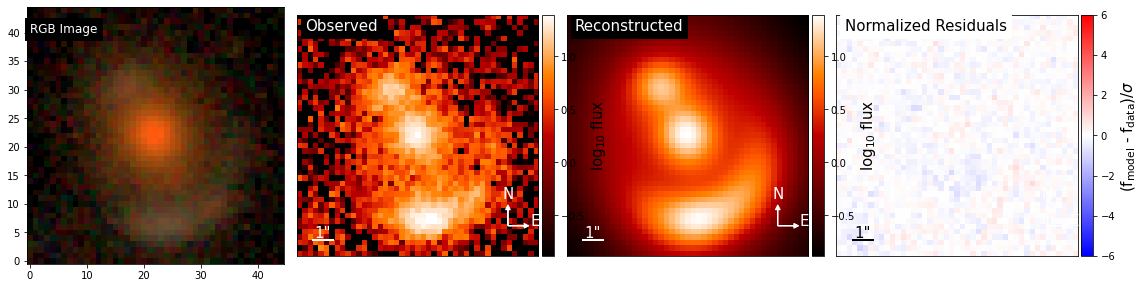

COADD_OBJECT_ID: 1015396778
The expected Einstein radius is 3.6402021  +-  0.4953744
The Einstein radius from the model is 3.3322747840507723


In [11]:
# test model:

model(coadd_id = 1015396778,
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial, 
      kwargs_source_initial = kwargs_source_initial)

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.37660123011356667 reduced X^2 of best position
-1139.2187210935392 logL
6050 effective number of data points
[{'theta_E': 4.26161010851982, 'e1': -0.4998123854732689, 'e2': 0.05568886909672009, 'center_x': -0.08607289391052723, 'center_y': 0.019781118719850204}, {'gamma1': -0.17562307270454044, 'gamma2': 0.19999051139687823, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 2.3600823141650817, 'n_sersic': 4.991881409847415, 'e1': -0.24465299823026912, 'e2': 0.49998791822850586, 'center_x': -1.8772408026280403, 'center_y': -0.3786253554314288}] source result
[{'amp': 1, 'R_sersic': 3.0089466646047347, 'n_sersic': 4.464234151524827, 'e1': 0.15773234498733957, 'e2': -0.16464282691996057, 'center_x': -0.2454986951544724, 'center_y': 0.04572016649325681}] lens light result
[] point source result
{} special param result
92.61242508888245 time used for  PS

100%|██████████████████████████████████████████████| 800/800 [05:31<00:00,  2.41it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
332.4694781303406 time taken for MCMC sampling
-0.37475975423458746 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.12867909472252684
reduced chi^2 of data  1 =  0.26737679242993
reduced chi^2 of data  2 =  0.7282233755513056


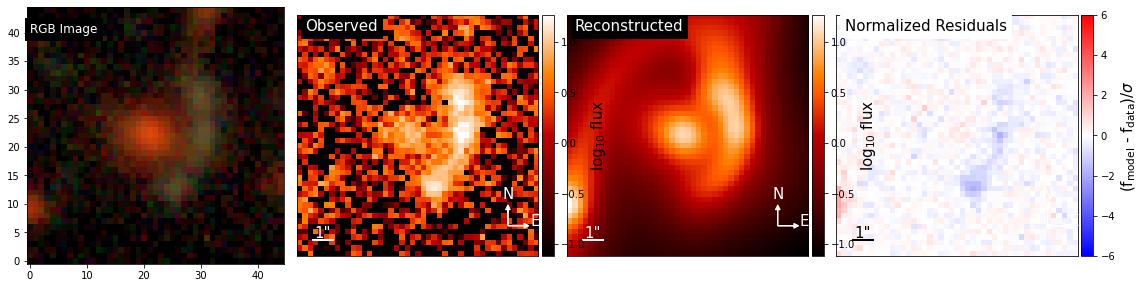

COADD_OBJECT_ID: 1194748640
The expected Einstein radius is 2.46834629  +-  0.37378494
The Einstein radius from the model is 4.331287179162263


In [17]:
# COADD = 1194748640

kwargs_lens_initial2 = {'theta_E': 3, 'e1': 0.05, 'e2': -0.05,'center_x': 0., 'center_y': 0.}
kwargs_source_initial2 = {'R_sersic': 1, 'n_sersic': 1, 'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0.}
kwargs_lens_light_initial2 = {'R_sersic': 4, 'n_sersic': 4, 'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0}

model(coadd_id = 1194748640,
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial, 
      kwargs_source_initial = kwargs_source_initial)


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.5035944771309047 reduced X^2 of best position
-1523.3732933209867 logL
6050 effective number of data points
[{'theta_E': 3.8866224663822067, 'e1': 0.01045413566939937, 'e2': 0.04270517731405342, 'center_x': -0.07725100336499593, 'center_y': -0.0002533606582374289}, {'gamma1': 0.07219603084528149, 'gamma2': -0.0035047358986165216, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.04928082729972349, 'n_sersic': 3.479916140054193, 'e1': 0.49803621010898946, 'e2': 0.1304219964289828, 'center_x': 0.33181758073734086, 'center_y': -0.20904986554196525}] source result
[{'amp': 1, 'R_sersic': 4.639810089731192, 'n_sersic': 4.121074476448405, 'e1': 0.13894907567352321, 'e2': -0.1593832907683713, 'center_x': 0.7325507147784651, 'center_y': -0.2126719503532312}] lens light result
[] point source result
{} special param result
128.07230401039124 time used for 

100%|██████████████████████████████████████████████| 800/800 [07:19<00:00,  1.82it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
439.7916359901428 time taken for MCMC sampling
-0.4337891624332036 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.22918320487170188
reduced chi^2 of data  1 =  0.25907903350997297
reduced chi^2 of data  2 =  0.8131052489179359


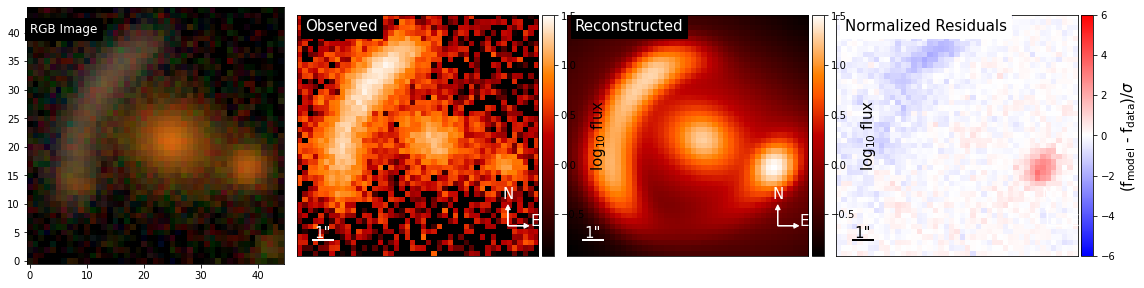

COADD_OBJECT_ID: 919882930
The expected Einstein radius is 3.70226639  +-  0.45413298
The Einstein radius from the model is 4.322989253001969


In [18]:
# COADD = 919882930

model(coadd_id = 919882930,
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial, 
      kwargs_source_initial = kwargs_source_initial)


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.2498884038285679 reduced X^2 of best position
-755.9124215814179 logL
6050 effective number of data points
[{'theta_E': 3.2355101561373534, 'e1': 0.3875034874870423, 'e2': 0.0021579034222610916, 'center_x': 0.13558001184241875, 'center_y': 0.06815304220673819}, {'gamma1': 0.09235107392783684, 'gamma2': 0.09430806879123184, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.03495970538761192, 'n_sersic': 2.2335527117643776, 'e1': 0.49973772527257526, 'e2': -0.45273366916319757, 'center_x': 0.2983593859735797, 'center_y': 0.6635524966843307}] source result
[{'amp': 1, 'R_sersic': 2.2309557743341544, 'n_sersic': 2.6663415739834546, 'e1': -0.07188380365651907, 'e2': -0.0038336317519621623, 'center_x': -0.008900310585441653, 'center_y': 0.04691070800341474}] lens light result
[] point source result
{} special param result
130.15753412246704 time used fo

100%|██████████████████████████████████████████████| 800/800 [06:14<00:00,  2.14it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
374.9502499103546 time taken for MCMC sampling
-0.24412103228437246 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.05861575446120313
reduced chi^2 of data  1 =  0.14567960497803709
reduced chi^2 of data  2 =  0.5280677374138772


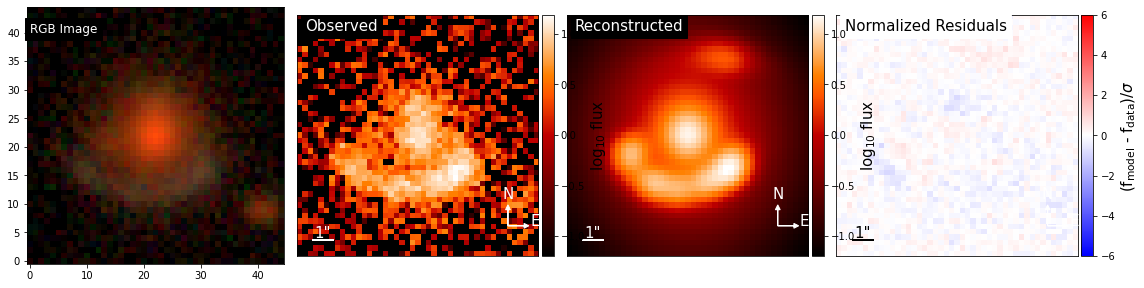

COADD_OBJECT_ID: 958711616
The expected Einstein radius is 3.15064048  +-  0.35580688
The Einstein radius from the model is 3.3613444462935687


In [19]:
# COADD = 958711616

model(coadd_id = 958711616,
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial, 
      kwargs_source_initial = kwargs_source_initial)